In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.mixture as exp_mix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore

In [131]:
np.random.seed(2024)

nmix = 2
dim = 1
std = 3.
n = 100

# mixture means and ratios
mean_ls = np.random.uniform(low=-10., high=10., size=(nmix, dim))

model_ratio_ls = np.random.uniform(size=(nmix))
model_ratio_ls = model_ratio_ls / np.sum(model_ratio_ls)

data_ratio_ls = np.random.uniform(size=(nmix))
data_ratio_ls = data_ratio_ls / np.sum(data_ratio_ls)

In [132]:
np.random.seed(10)
X = exp_mix.sample_mixture(n, mean_ls, data_ratio_ls, std)

In [133]:
data_ratio_ls

array([0.65905152, 0.34094848])

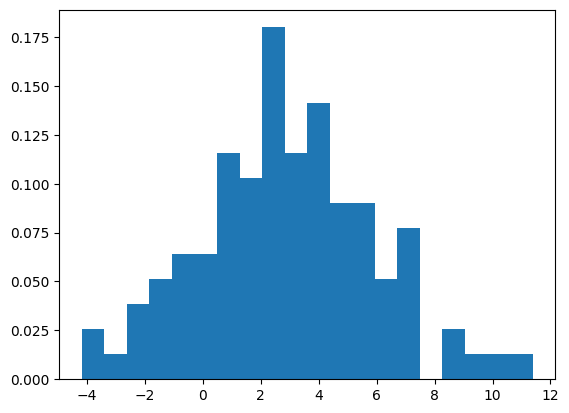

In [134]:
_ = plt.hist(X[:, 0].reshape(-1), bins=20, density=True)

In [135]:
log_prob_fn = exp_mix.make_log_prob(mean_ls, model_ratio_ls, std)
score_fn = exp_mix.make_score(mean_ls, model_ratio_ls, std)

xx = X[:10]
xx = np.eye(dim)[:1] * 100.
print(log_prob_fn(xx))
print(score_fn(xx))

[-513.8569]
[[-10.668647]]


In [136]:
np.random.seed(10)
nrep = 20
n = 100

Xs = jnp.empty((nrep, n, dim), dtype=jnp.float32)
scores = jnp.empty((nrep, n, dim), dtype=jnp.float32)

for i in range(nrep):
    X = exp_mix.sample_mixture(n, mean_ls, data_ratio_ls, std)
    Xs = Xs.at[i].set(X)

    score = score_fn(X)
    scores = scores.at[i].set(score)

res = exp_utils.run_tests(
    samples=Xs, scores=scores, hvps=None, hvp_denom_sup=None,
    theta=0.1, bw="med", alpha=0.05, verbose=True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.85it/s]


In [137]:
res["standard"]["stat"]

[Array(0.00380071, dtype=float32),
 Array(0.00443759, dtype=float32),
 Array(0.00129755, dtype=float32),
 Array(0.00789136, dtype=float32),
 Array(0.00311997, dtype=float32),
 Array(0.00132523, dtype=float32),
 Array(0.0044415, dtype=float32),
 Array(0.00046322, dtype=float32),
 Array(0.00345527, dtype=float32),
 Array(0.00265669, dtype=float32),
 Array(0.00225971, dtype=float32),
 Array(0.0044005, dtype=float32),
 Array(0.00372059, dtype=float32),
 Array(0.00066117, dtype=float32),
 Array(0.00338734, dtype=float32),
 Array(0.00177894, dtype=float32),
 Array(0.00068961, dtype=float32),
 Array(0.00050507, dtype=float32),
 Array(0.00124762, dtype=float32),
 Array(0.00605934, dtype=float32)]

In [138]:
res["standard"]["rej"]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

# Load

In [91]:
n = 500
d = 1
res_stats = pickle.load(open(f"../data/mixture/stats_n{n}_d{d}.pkl", "rb"))

std_ls = list(res_stats.keys())
std_ls

[0.01, 0.1, 0.5, 1.0, 5.0]

In [93]:
tau = pickle.load(open(f"../data/mixture/tau_d{d}.pkl", "rb"))
tau

{0.01: Array(3.496258e+09, dtype=float32),
 0.1: Array(370916.3, dtype=float32),
 0.5: Array(599.9684, dtype=float32),
 1.0: Array(42.571224, dtype=float32),
 5.0: Array(0.05029342, dtype=float32)}

In [95]:
# change theta
eps0_ls = [0.05, 0.1, 0.25]
plot_df_ls = {}

for i, eps0 in enumerate(eps0_ls):
    # change theta
    res_stats_new = copy.deepcopy(res_stats)
    for std in std_ls:
        theta_new = eps0 * tau[std]**0.5
        
        res_stats_new[std] = exp_utils.change_theta(res_stats_new[std], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)
    
    methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    plot_df = {"std": [], "nonsq_stat": [], "method": [], "rej": []}
    for std in std_ls:
        for m, m_label in methods.items():
            rr = res_stats_new[std][m]
            plot_df["nonsq_stat"].extend(np.array(rr["nonsq_stat"]).tolist())
            plot_df["std"].extend([std] * len(rr["nonsq_stat"]))
            
            plot_df["rej"].extend(rr["rej"])
            plot_df["method"].extend([m_label] * len(rr["nonsq_stat"]))
    
    plot_df = pd.DataFrame(plot_df)
    plot_df_ls[eps0] = plot_df

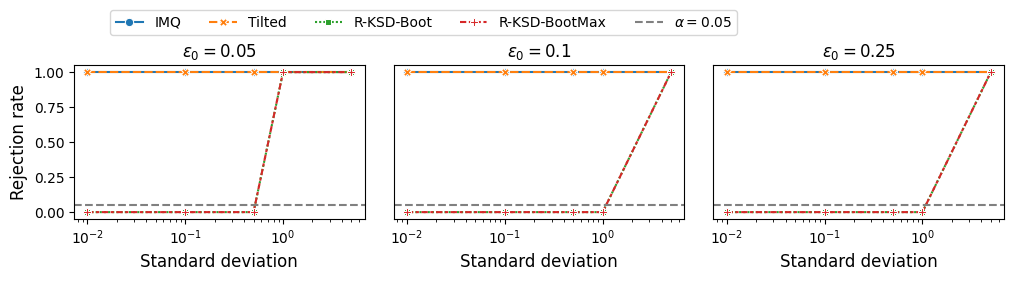

In [97]:
_, axes = plt.subplots(ncols=len(eps0_ls), figsize=(4*len(eps0_ls), 2))

for i, eps0 in enumerate(eps0_ls):
    plot_df = plot_df_ls[eps0]

    ax = axes[i]
    _ = sns.lineplot(ax=ax, data=plot_df, x="std", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha=0.05$")
    ax.set_xlabel("Standard deviation", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xscale("log")
    ax.set_title(rf"$\epsilon_0 = ${eps0}")
    if i > 0:
        ax.legend([],[], frameon=False)
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

lgd = axes[0].legend(bbox_to_anchor=(0.1, 1.15, 1, 0.2), loc="lower left", ncol=6)

plt.subplots_adjust(wspace=0.1)
# plt.savefig("../figs/robust/tail.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

In [98]:
params_setup = pickle.load(open(f"../data/mixture/setup_d{d}.pkl", "rb"))
params_setup

{'means': array([[ 1.76029038],
        [ 3.98217495],
        [-6.2369608 ],
        [-9.12382873],
        [-5.89962095]]),
 'model_ratios': array([0.04356042, 0.29868025, 0.27903234, 0.19461021, 0.18411678]),
 'data_ratios': array([0.00636835, 0.25084102, 0.2007961 , 0.32056046, 0.22143407])}